In [164]:
## find L, M, S functions by age/sex/region
# We calculated the centiles (0.4, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 99.6) for each regional 
# # cortical thickness measure by sex and hemisphere as normalized growth centiles using parametric 
# # Lambda (λ), Mu (μ), Sigma (σ) (LMS) method (Cole and Green, 1992) in the Generalized Additive Models
# #  for Location, Scale and Shape (GAMLSS) package in R (http://cran.r-project.org/web/packages/gamlss/index.html) 
# #(Rigby & Stasinopoulos, 2005; Stasinopoulos & Rigby, 2007). LMS is considered a powerful method for estimating 
# #centile curves based on the distribution of a response variable at each covariate value (in this case age).
# # GAMLSS uses a penalized maximum likelihood function to estimate parameters of smoothness (effective degrees of 
# #freedom) which are then used to estimate the λ, μ, and σ parameters. The goodness of fit for these parameters in 
# #the GAMLSS algorithm is established by minimizing the Generalized Akaike Information Criterion (GAIC) index.

# if we can estimate L,M,S then we can estimate centiles and therefore z-scores for each subject and region.

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [418]:
# load the centile information
# male
male_centiles = pd.read_csv('/Users/emilyolafson/GIT/ENIGMA/cortical_atrophy/centiles_CT_males.csv', header=0)
male_centiles.rename(columns={'Unnamed: 0':'Region'},inplace = True)

# female
female_centiles = pd.read_csv('/Users/emilyolafson/GIT/ENIGMA/cortical_atrophy/centiles_CT_females.csv', header=0)
female_centiles.rename(columns={'Unnamed: 0':'Region'},inplace = True)

# load cortical thickness data to get headers (regions)
rh_thickness =  pd.read_table('/Users/emilyolafson/GIT/ENIGMA/data/FREESURFER/aseg_aparc/aparc_rh_stats_thickness.txt', header=0)
lh_thickness =  pd.read_table('/Users/emilyolafson/GIT/ENIGMA/data/FREESURFER/aseg_aparc/aparc_lh_stats_thickness.txt', header=0)


# change col names so they match centile naming
newRcols=[]
newLcols=[]
for x in rh_thickness.columns: newRcols.append(x.replace('_thickness', '').replace('rh_', 'R_'))
for x in lh_thickness.columns: newLcols.append(x.replace('_thickness', '').replace('lh_', 'L_'))

rh_thickness.columns = newRcols
lh_thickness.columns = newLcols

#find zeros or nans where there shouldn't be them!
lh_na=lh_thickness.isna()
rh_na=rh_thickness.isna()

In [469]:
list_centiles = [0.004, 0.01, 0.025, .05, .10, .25, .50, .75, .90, .95, .975, 0.99, .996]
ages =[20,30,40,50,6,70,80,90]
f_agerange= [5,10,15,20,30,40,50,60,70,80,90]
m_agerange=[3,5,10,15,20,30,40,50,60,70,80,90]
age_start=m_agerange.index(ages[0])
print(age_start+len(ages))
min_ssd = np.empty((len(rh_thickness.columns),len(ages)))
best_params = np.empty((len(rh_thickness.columns),len(ages),3))
cpreds = np.empty((len(rh_thickness.columns),len(ages),13))
creal = np.empty((len(rh_thickness.columns),len(ages),13))

#for regionid in range(1,len(rh_thickness.columns)+1):
for regionid in range(1,2):
    region = rh_thickness.columns[regionid]
    print(region)

    #male
    idx=np.empty((len(list_centiles),1))

    for i in range(0,len(list_centiles)): idx[i] =np.where(male_centiles['Region']==region)[0][0]+i

    for age in range(age_start,age_start+len(ages)):
        centiles = male_centiles.iloc[idx[age]] #
        centiles=centiles.values[0][2:15] # get rid of first 2 cols
        
        Z = st.norm.ppf(list_centiles) #alpha to Z via norm

        Calphas_true = centiles
        M=[]
        L=[]
        S=[]

        nM =100
        nL =100
        nS =100
        Ms = np.linspace(1,5,nM)
        Ls = np.linspace(0.5,2,nL)
        Ss = np.linspace(-0.1,0.1,nS)

        Mc=np.arange(0,nM)
        Sc=np.arange(0,nS)
        Lc=np.arange(0,nL)

        ssd = np.empty((nM,nL,nS))
        lowestssd=1
        for m in Mc: 
            M = Ms[m]
            for l in Lc: 
                L=Ls[l]
                for s in Sc:
                    S = Ss[s]
                    Calpha_pred = pow(M*(1+S*Z*L),1/L)
                    
                    ssd[m,l,s]=np.sum((Calpha_pred-Calphas_true)**2)
                    if ssd[m,l,s] < lowestssd:
                        lowestssd = ssd[m,l,s]
                        Cpreds = Calpha_pred
                        calphs=Calphas_true
                        bestmls = [M,L,S]
                        print(M)
                        print(bestmls)

        min_ssd[regionid-1,age-4]=np.nanmin(ssd)
        best_params[regionid-1,age-4,:]=bestmls
        cpreds[regionid-1, age-4,:]=Cpreds
        creal[regionid-1,age-4,:]=calphs
    

12
R_bankssts
1.5656565656565657
[1.5656565656565657, 0.5, 0.0414141414141414]
1.5656565656565657
[1.5656565656565657, 0.5, 0.043434343434343436]
1.5656565656565657
[1.5656565656565657, 0.5, 0.04545454545454544]
1.5656565656565657
[1.5656565656565657, 0.5, 0.047474747474747475]
1.5656565656565657
[1.5656565656565657, 0.5, 0.04949494949494948]
1.5656565656565657
[1.5656565656565657, 0.5, 0.051515151515151514]
1.5656565656565657
[1.5656565656565657, 0.5, 0.05353535353535352]
1.5656565656565657
[1.5656565656565657, 0.5, 0.05555555555555555]
1.5656565656565657
[1.5656565656565657, 0.5, 0.05757575757575756]
1.5656565656565657
[1.5656565656565657, 0.5, 0.05959595959595959]
1.5656565656565657
[1.5656565656565657, 0.5, 0.0616161616161616]
1.5656565656565657
[1.5656565656565657, 0.5, 0.06363636363636363]
1.5656565656565657
[1.5656565656565657, 0.5, 0.06565656565656566]
1.5656565656565657
[1.5656565656565657, 0.5, 0.06767676767676767]
1.5656565656565657
[1.5656565656565657, 0.5, 0.06969696969696

[1.98118131 2.18566049 2.24773196 2.31736668 2.37710436 2.44580932
 2.56022452 2.68680601 2.81284745 2.92585052 2.99328801 3.0516682
 3.11942051 3.17954131 3.37576454]


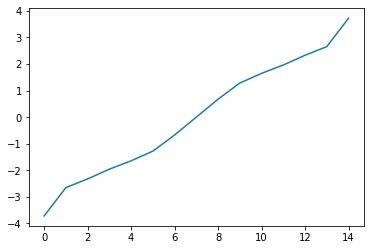

In [512]:
# if i have M,L,and S and I want to have able to find the zscore for any age (continuous)
# i need to have basically a distribution for that age thats the normal healthy distribution
# with MLS and z I can generate a Calpha
# if I just 
list_centiles = [0.0001, 0.004, 0.01, 0.025, .05, .10, .25, .50, .75, .90, .95, .975, 0.99, .996, 0.9999]

#list_centiles = np.linspace(0.00001,1,100)
Z = st.norm.ppf(list_centiles) #alpha to Z via norm
plt.plot(Z)

mls1=best_params[0,:,:]

M=best_params[0,0,0]
L=best_params[0,0,1]
S=best_params[0,0,2]

Calpha_pred = pow(M*(1+S*Z*L),1/L)
print(Calpha_pred)

In [502]:
print(Calpha_pred)

[[1.87583008 2.0646424  2.10252857 ... 2.68633615 2.68657108 2.68680601]
 [2.68680601 2.68704095 2.68727588 ... 3.26019906 3.29703686        inf]]


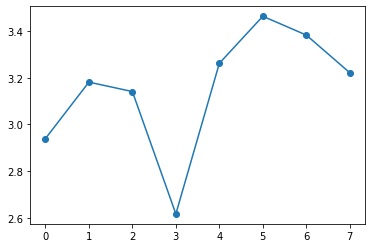

In [470]:
plt.plot((best_params[0,:,0]),marker='o')

In [471]:
mls1=best_params[0,:,:]
preds = cpreds[0,0,:]
trues = creal[0,0,:]

print(mls1)
M=mls1[0,0]
L=mls1[0,1]
S=mls1[0,2]

print(preds)
Calpha_pred = pow(M*(1+S*Z*L),1/L)
print(Calpha_pred)


[[2.93939394 1.09090909 0.06969697]
 [3.18181818 1.21212121 0.06969697]
 [3.14141414 1.22727273 0.07171717]
 [2.61616162 1.06060606 0.07373737]
 [3.26262626 1.33333333 0.07373737]
 [3.46464646 1.42424242 0.07575758]
 [3.38383838 1.43939394 0.07777778]
 [3.22222222 1.43939394 0.07979798]]
[2.18566049 2.24773196 2.31736668 2.37710436 2.44580932 2.56022452
 2.68680601 2.81284745 2.92585052 2.99328801 3.0516682  3.11942051
 3.17954131]
[2.18566049 2.24773196 2.31736668 2.37710436 2.44580932 2.56022452
 2.68680601 2.81284745 2.92585052 2.99328801 3.0516682  3.11942051
 3.17954131]


[2.18566049 2.24773196 2.31736668 2.37710436 2.44580932 2.56022452
 2.68680601 2.81284745 2.92585052 2.99328801 3.0516682  3.11942051
 3.17954131]


array([[1.        , 0.99988292],
       [0.99988292, 1.        ]])

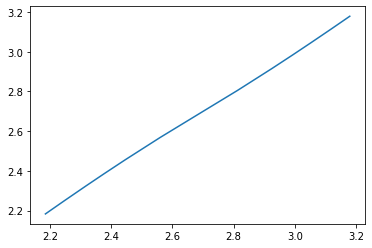

In [472]:
plt.plot(preds,trues)
print(preds)
np.corrcoef(preds, trues)

0.9999204638037263

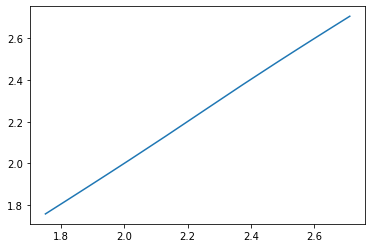

In [473]:
plt.plot(Cpreds,Calphas_true)
from sklearn.metrics import explained_variance_score
explained_variance_score(Cpreds,Calphas_true)

[[2.18566049 2.24773196 2.31736668 2.37710436 2.44580932 2.56022452
  2.68680601 2.81284745 2.92585052 2.99328801 3.0516682  3.11942051
  3.17954131]
 [2.10775446 2.16923191 2.23794561 2.29668674 2.36401877 2.47563307
  2.59840696 2.71996195 2.82838677 2.89285322 2.94852227 3.01297074
  3.07002187]
 [2.04643494 2.10858325 2.1779965  2.23729552 2.3052236  2.41772917
  2.54135288 2.66362408 2.77258968 2.83733618 2.89322316 2.95789715
  3.01512464]
 [1.98891396 2.04912925 2.11673382 2.17477282 2.24157191 2.35292344
  2.47627015 2.59924545 2.70962577 2.7755531  2.83265838 2.8989681
  2.95784148]
 [1.93540752 1.99795284 2.06753563 2.12676146 2.19437043 2.30582485
  2.42759087 2.54735321 2.65355817 2.71644267 2.77059493 2.83311864
  2.8883194 ]
 [1.88852407 1.95333666 2.02516738 2.0860912  2.15540933 2.26918059
  2.39281685 2.51379912 2.6206099  2.68365456 2.73783156 2.80025799
  2.8552643 ]
 [1.82605807 1.89134534 1.96361978 2.02485648 2.09446433 2.2085693
  2.33238566 2.45337753 2.56007181

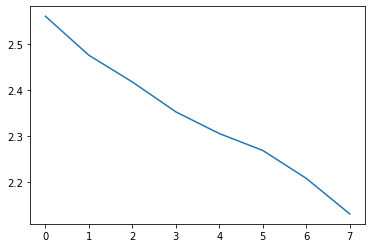

In [474]:
plt.plot(cpreds[0,:,5])
print(cpreds[0,:,:])